<a href="https://www.kaggle.com/code/shubhamvm/inceptionpretrained?scriptVersionId=166736687" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import libraries

In [1]:
import tensorflow as tf
import glob as gb
from PIL import Image
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from tensorflow.keras import datasets,models,layers
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib.pyplot as plt
import os,cv2
from keras.applications import InceptionV3
import random
import seaborn as sns

# Tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

# sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

2024-03-12 23:00:12.305009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 23:00:12.305135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 23:00:12.436646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading and Formatting Data

In [2]:
def get_key_from_value(dictionary, value):
    return next((key for key, val in dictionary.items() if val == value), None)

In [3]:
# Your label mapping and file paths
labels = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

train_folder = r"/kaggle/input/intel-image-classification/seg_train/seg_train"
test_folder = r"/kaggle/input/intel-image-classification/seg_train/seg_train"
pred_folder = r"/kaggle/input/intel-image-classification/seg_pred"

# Load training data
train_img = []
train_lbl = []

# Define common size for resizing
common_size = (224, 224)

for folder in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, folder)
    files = gb.glob(pathname=os.path.join(folder_path, "*.jpg"))
    for file in files:
        image = Image.open(file)
        image = image.resize(common_size)  # Resize image to a common size
        train_img.append(np.array(image))
        train_lbl.append(labels.get(folder, -1))

train_img = np.array(train_img)
train_lbl = np.array(train_lbl)

# Load testing data
test_img = []
test_lbl = []
for folder in os.listdir(test_folder):
    folder_path = os.path.join(test_folder, folder)
    files = gb.glob(pathname=os.path.join(folder_path, "*.jpg"))
    for file in files:
        image = Image.open(file)
        image = image.resize(common_size)  # Resize image to a common size
        test_img.append(np.array(image))
        test_lbl.append(labels.get(folder, -1))

test_img = np.array(test_img)
test_lbl = np.array(test_lbl)

# Load prediction data
pred_img = []
for folder in os.listdir(pred_folder):
    folder_path = os.path.join(pred_folder, folder)
    files = gb.glob(pathname=os.path.join(folder_path, "*.jpg"))
    for file in files:
        image = Image.open(file)
        image = image.resize(common_size)  # Resize image to a common size
        pred_img.append(np.array(image))

pred_img = np.array(pred_img)

# Check the number of items in each set and their shapes
print("Number of items in the training set:", len(train_img))
print("Number of items in the testing set:", len(test_img))
print("Number of items in the prediction set:", len(pred_img))

Number of items in the training set: 14034
Number of items in the testing set: 14034
Number of items in the prediction set: 7301


In [4]:
print("Shape of train_img:", train_img.shape)
print("Shape of train_lbl:", train_lbl.shape)
print("Shape of test_img:", test_img.shape)
print("Shape of test_lbl:", test_lbl.shape)
print("Shape of pred_img:", pred_img.shape)

Shape of train_img: (14034, 224, 224, 3)
Shape of train_lbl: (14034,)
Shape of test_img: (14034, 224, 224, 3)
Shape of test_lbl: (14034,)
Shape of pred_img: (7301, 224, 224, 3)


Train and Test split

In [5]:
# Split the data into training and testing sets
train_img, test_img1, train_lbl, test_lbl1 = train_test_split(train_img, train_lbl, test_size=0.2, random_state=42)

# Sample Data

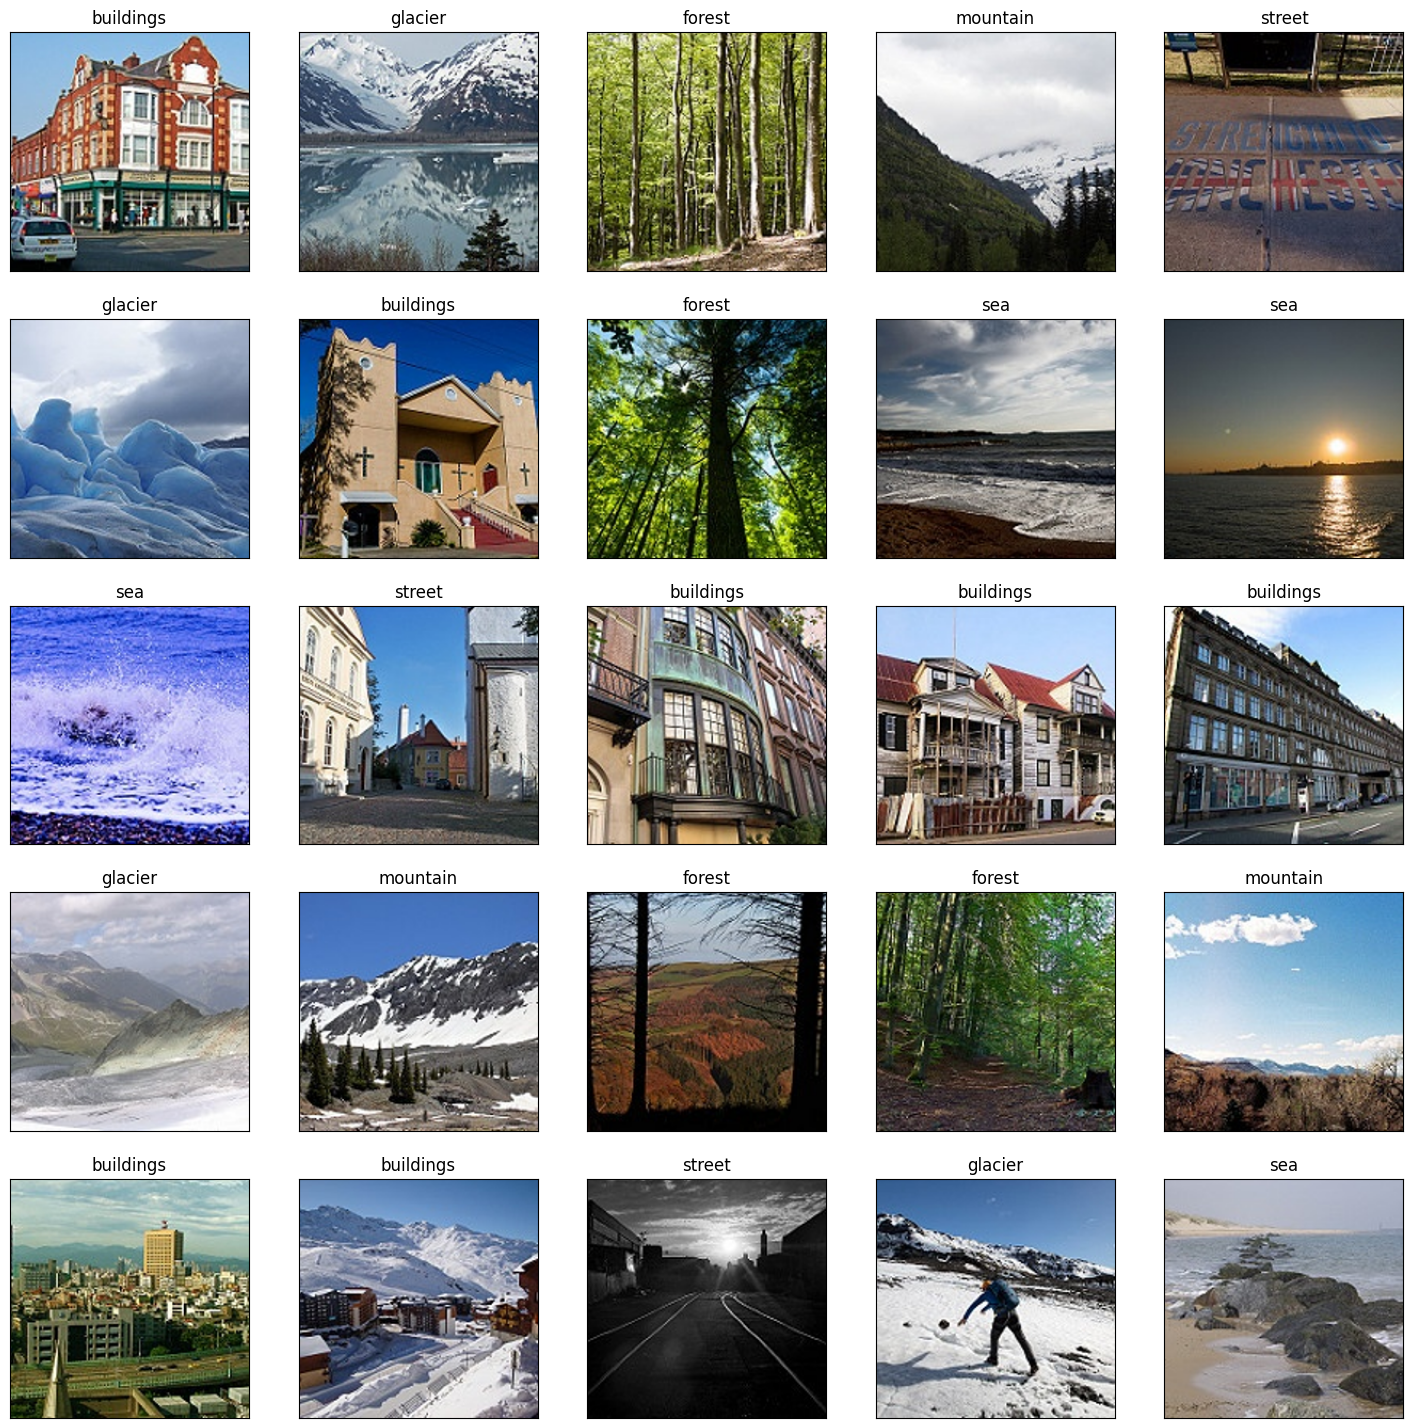

In [6]:
plt.figure(figsize=(18, 18))

random_list = random.sample(range(len(train_img)), 25)
i = 0
for j in random_list:
    plt.subplot(5, 5, i+1)
    plt.imshow(train_img[j])
    label_code = train_lbl[j]
    label_name = [key for key, value in labels.items() if value == label_code][0]
    plt.title(label_name)
    plt.xticks([])
    plt.yticks([])
    i+=1

plt.show()

# Fine Tuning and freezing using pre trained inceptionv3

## Model 1 building and evaluation

In [7]:
TotalClasses=6

# Load InceptionV3 pre-trained on ImageNet
inception1 = InceptionV3(input_shape=train_img[0].shape, weights='imagenet', include_top=False)

# Freeze layers of the pre-trained model
for layer in inception1.layers:
    layer.trainable = False

# Unfreeze the last twenty layers for fine-tuning
for layer in inception1.layers[-20:]:
    layer.trainable = True

last_layer1 = inception1.get_layer('mixed7')
last_output1 = last_layer1.output

# Add custom classification head
x1 = layers.Flatten()(last_output1)
x1 = layers.Dense(1024, activation='relu')(x1)
x1 = layers.Dropout(0.2)(x1)                   
pred1=layers.Dense(TotalClasses,activation="softmax")(x1)
# Create the fine-tuned model
model1 = models.Model(inputs=inception1.input, outputs=pred1)
#model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
model1.compile(optimizer="adam" , loss='sparse_categorical_crossentropy',metrics=['accuracy'])
early = EarlyStopping(patience=5, restore_best_weights=True)
# Train the model
history1 = model1.fit(train_img, train_lbl, epochs=20, validation_data=(test_img1, test_lbl1), callbacks=[early])

Epoch 1/20
  2/351 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.2969 - loss: 538.2183  

I0000 00:00:1710284658.590196      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710284658.636501      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3737 - loss: 343.4117

W0000 00:00:1710284689.890225      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 120ms/step - accuracy: 0.3736 - loss: 342.7089 - val_accuracy: 0.3477 - val_loss: 1.6423
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.3174 - loss: 1.6643 - val_accuracy: 0.3502 - val_loss: 1.5434
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.3356 - loss: 1.5426 - val_accuracy: 0.3947 - val_loss: 1.5475
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.3457 - loss: 1.4979 - val_accuracy: 0.3174 - val_loss: 1.6076
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.3533 - loss: 1.4794 - val_accuracy: 0.3245 - val_loss: 1.4951
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.3631 - loss: 1.4531 - val_accuracy: 0.4125 - val_loss: 1.3572
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.3698 - loss: 1.4271 - val_accuracy: 0.4068 - val_loss: 1.3511
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.4038 - loss: 1.3550 - val_accu

In [9]:
#model evaluation
loss1 , acc1 = model1.evaluate(test_img , test_lbl)
print("Accuracy : ",acc1)
print("loss : " , loss1)

439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.2710 - loss: 1.2268
Accuracy :  0.48503634333610535
loss :  1.150804877281189


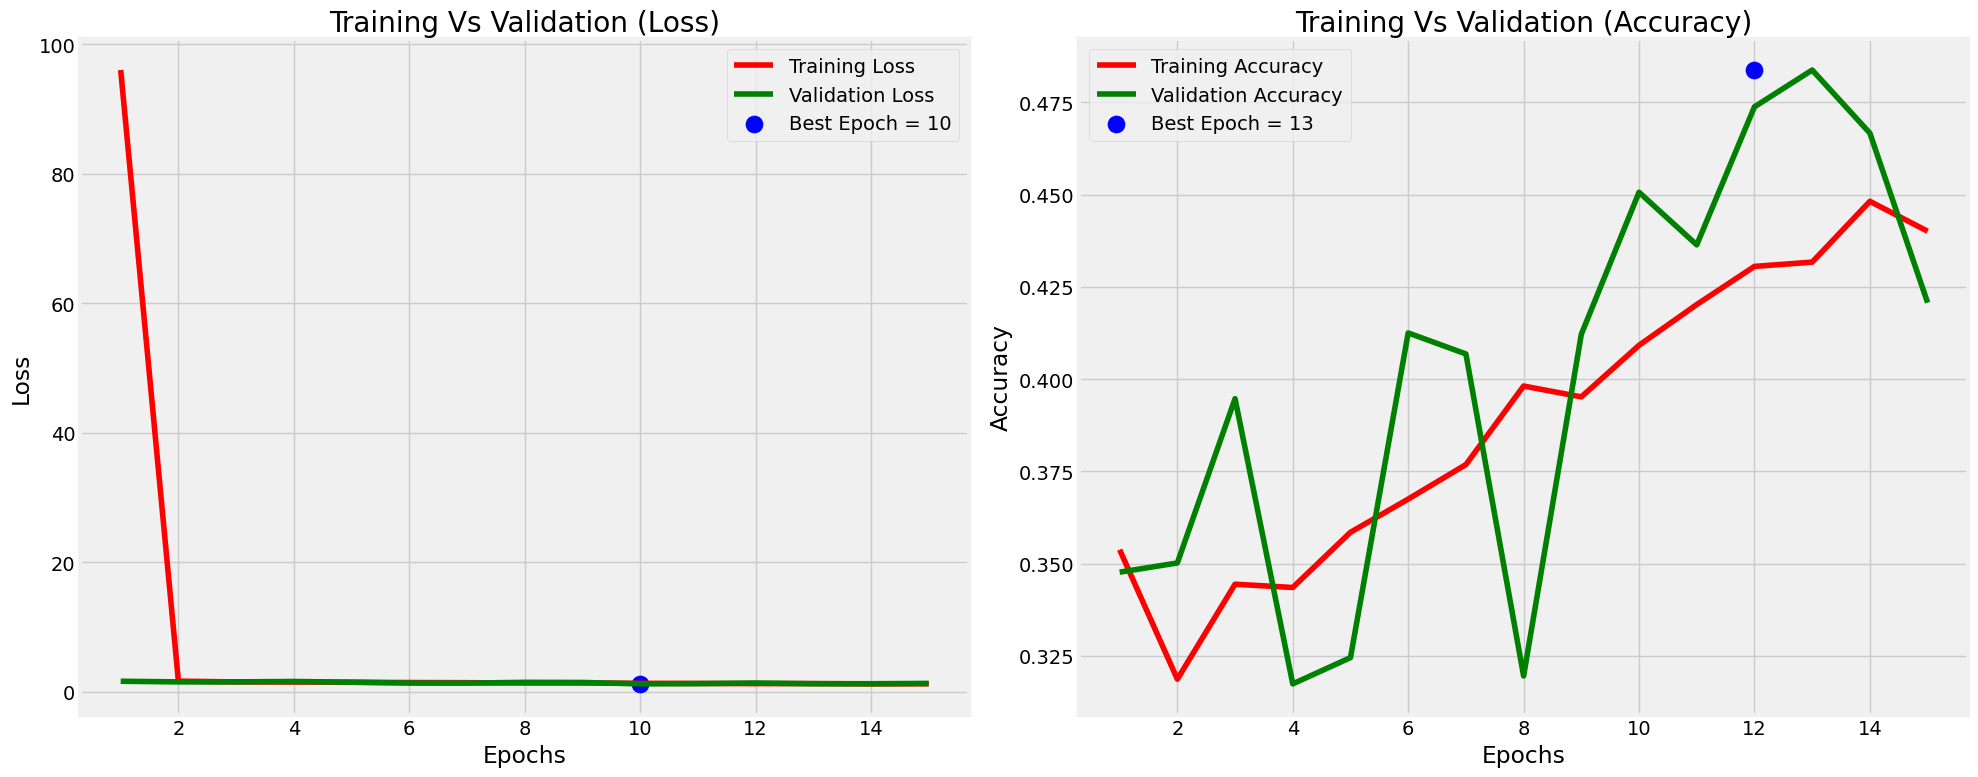

In [10]:
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']

val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Model 2 building and Evaluation

In [11]:
#Different approach

TotalClasses=6

# Load InceptionV3 pre-trained on ImageNet
inception2 = InceptionV3(input_shape=train_img[0].shape, weights='imagenet', include_top=False)

# Freeze layers of the pre-trained model
for layer in inception2.layers:
    layer.trainable = False

# Unfreeze the first twenty layers for fine-tuning
for layer in inception2.layers[20:]:
    layer.trainable = True

last_layer2 = inception2.get_layer('mixed7')
last_output2 = last_layer2.output

# Add custom classification head
x2 = layers.Flatten()(last_output2)
x2 = layers.Dense(1024, activation='relu')(x2)
x2 = layers.Dropout(0.2)(x2)                   
pred2 = layers.Dense(TotalClasses,activation="softmax")(x2)
# Create the fine-tuned model
model2 = models.Model(inputs=inception2.input, outputs=pred2)
#model.summary()

In [12]:
model2.compile(optimizer="adam" , loss='sparse_categorical_crossentropy',metrics=['accuracy'])
early = EarlyStopping(patience=5, restore_best_weights=True)
# Train the model
history2 = model2.fit(train_img, train_lbl, epochs=20, validation_data=(test_img1, test_lbl1), callbacks=[early])

Epoch 1/20
  2/351 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - accuracy: 0.2344 - loss: 7.0100  

W0000 00:00:1710285071.052177      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5882 - loss: 1.8434

W0000 00:00:1710285143.004163      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 136s 224ms/step - accuracy: 0.5886 - loss: 1.8408 - val_accuracy: 0.6430 - val_loss: 1.1783
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.8354 - loss: 0.4925 - val_accuracy: 0.5725 - val_loss: 1.1575
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.8574 - loss: 0.4224 - val_accuracy: 0.5967 - val_loss: 1.1239
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.8723 - loss: 0.3677 - val_accuracy: 0.7207 - val_loss: 0.7760
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.8876 - loss: 0.3354 - val_accuracy: 0.7378 - val_loss: 0.9628
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.8908 - loss: 0.3362 - val_accuracy: 0.8383 - val_loss: 0.4731
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.9142 - loss: 0.2512 - val_accuracy: 0.8272 - val_loss: 0.5825
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.9148 - loss: 0.2617 - va

In [13]:
#tf.keras.utils.plot_model(model, '/kaggle/working/model.png', show_shapes=True)

In [14]:
#model evaluation
loss2 , acc2 = model2.evaluate(test_img , test_lbl)
print("Accuracy : ",acc2)
print("loss : " , loss2)

439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.8687 - loss: 0.3556
Accuracy :  0.8758016228675842
loss :  0.34298160672187805


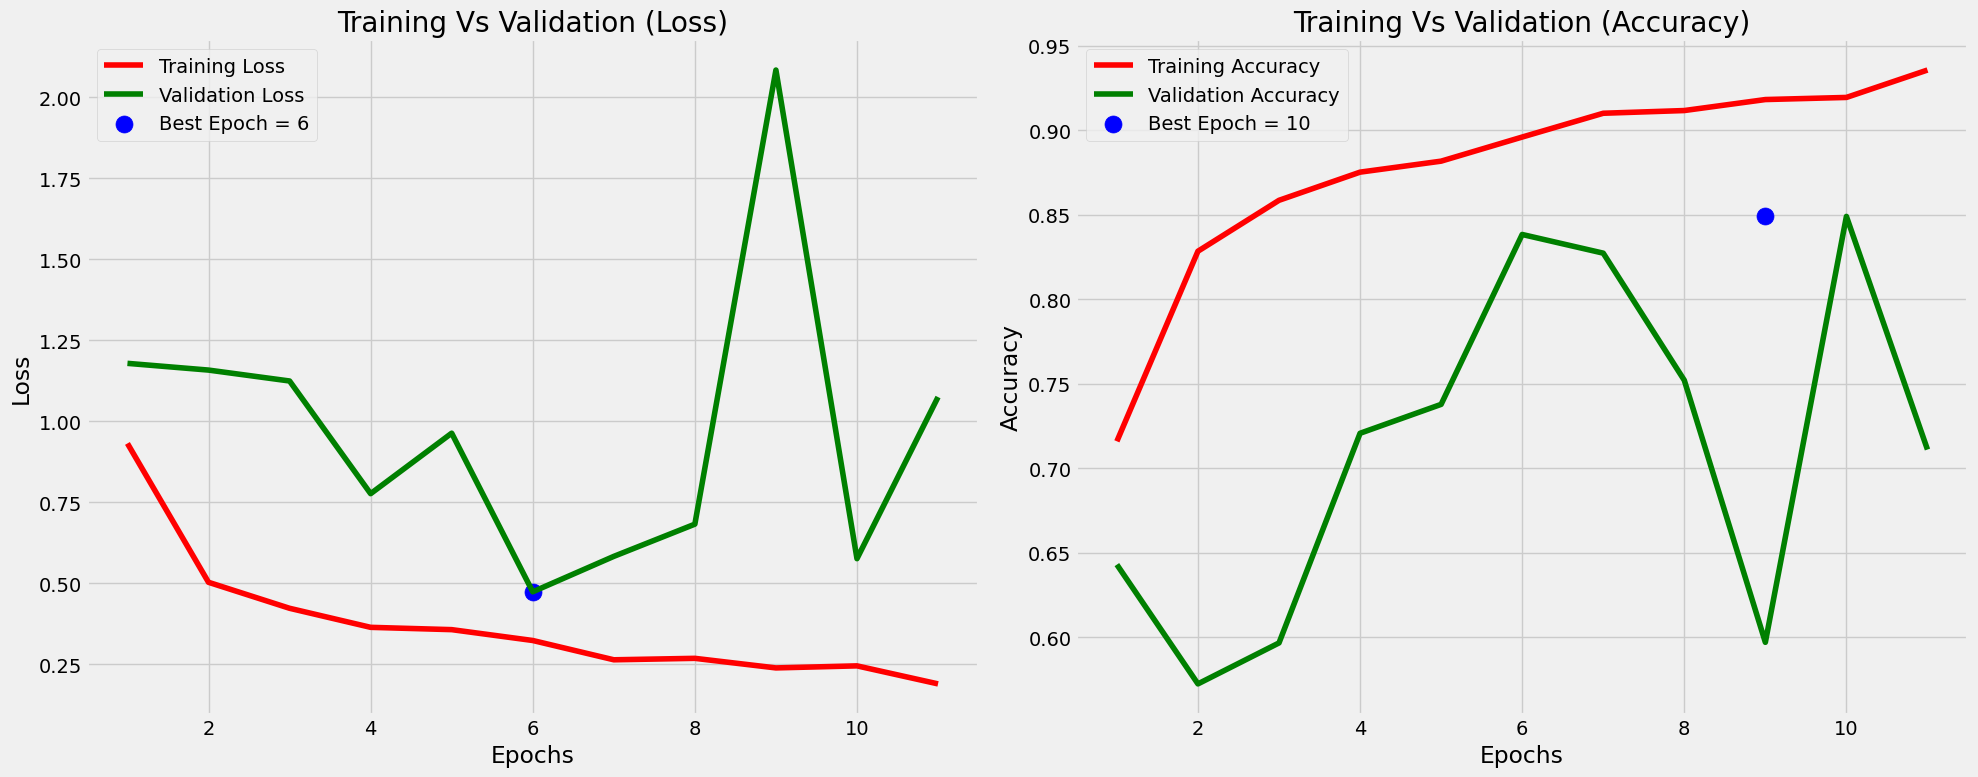

In [15]:
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']

val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Model Predictions

In [16]:
#Prediction and accuracy check on test data
predictions1 = model1.predict(test_img)    
pred_lbl1 = np.argmax(predictions1, axis = 1)
print("Model 1 Accuracy on test : {}".format(accuracy_score(test_lbl, pred_lbl1)))

  8/439 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step

W0000 00:00:1710285589.137931      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step
Model 1 Accuracy on test : 0.4850363403163745


In [17]:
predictions2 = model2.predict(test_img)    
pred_lbl2 = np.argmax(predictions2, axis = 1)
print("Model 2 Accuracy on test : {}".format(accuracy_score(test_lbl, pred_lbl2)))

  8/439 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step

W0000 00:00:1710285616.689896      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step
Model 2 Accuracy on test : 0.8758016246259085


# Predictions using better model

229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step


W0000 00:00:1710285650.810779      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[4 5 3 ... 0 1 0]


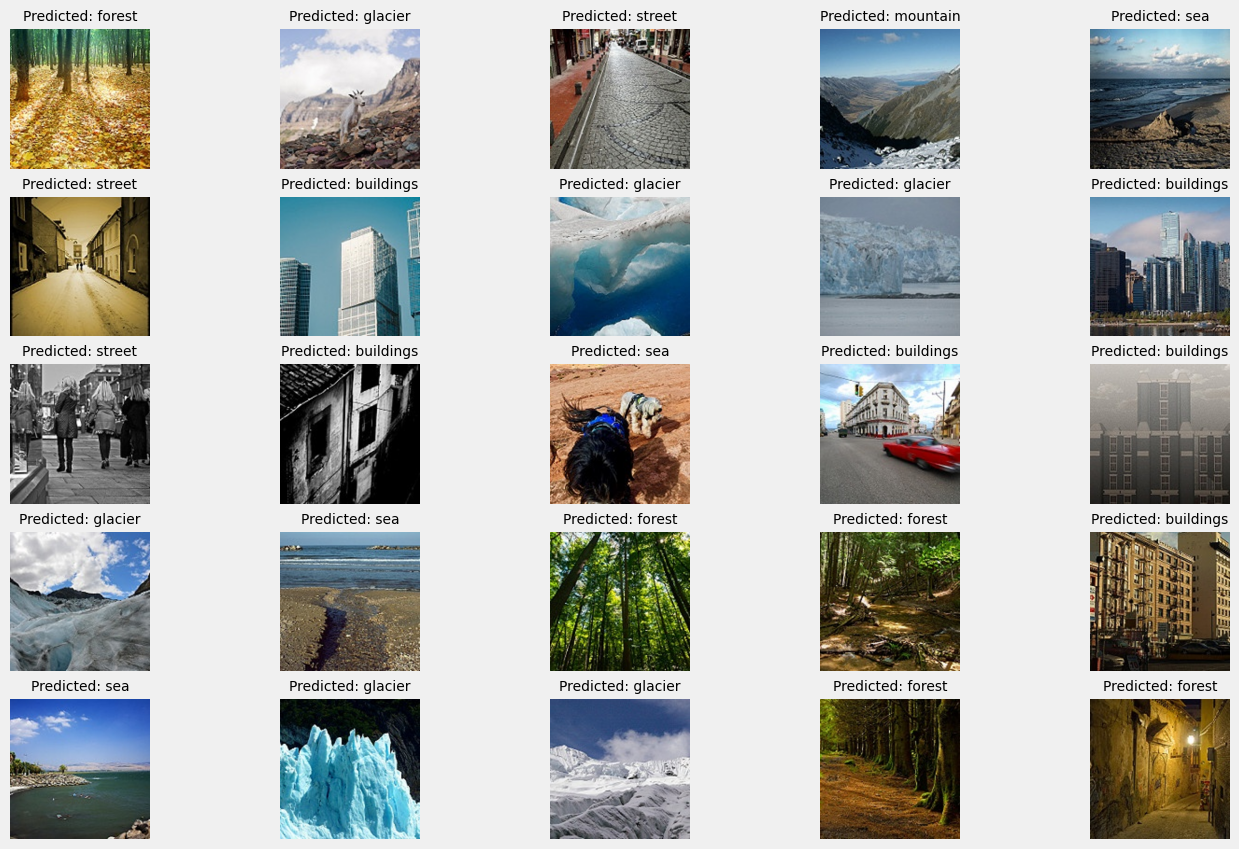

In [18]:
#choosing the better model for predictions
predictions = model2.predict(pred_img)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes)

# Visualize the predictions
plt.figure(figsize=(15, 10))
random_list2 = random.sample(range(7001), 25)
j=0
for i in random_list2: 
    plt.subplot(5, 5, j + 1)
    plt.imshow(pred_img[i], cmap='gray')
    label1 = get_key_from_value(labels, predicted_classes[i])
    label_code = predicted_classes[i]
    label_name = [key for key, value in labels.items() if value == label_code][0]
    
    plt.title(f"Predicted: {label_name}", fontsize=10)
    plt.axis('off')
    j+=1
plt.show()

In [19]:
model2.save("InceptionModel2.h5") # saving the model

# Confusion matrix and classification report

439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step


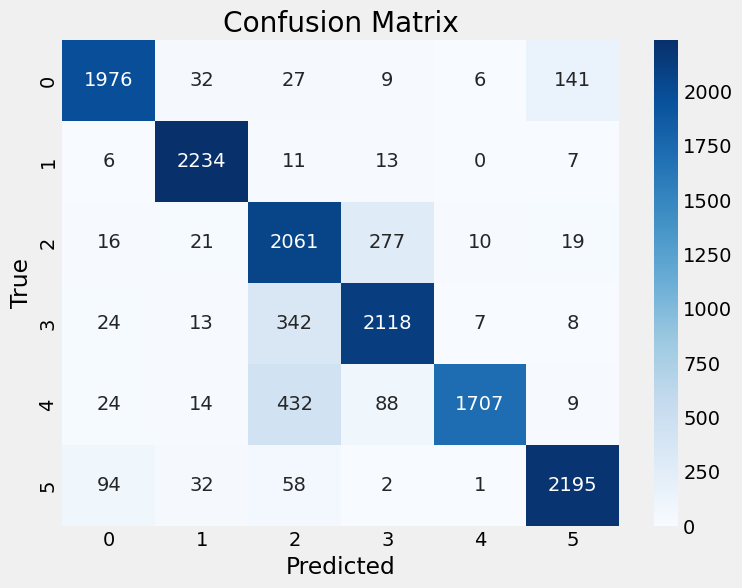


Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.90      0.91      2191
      forest       0.95      0.98      0.97      2271
     glacier       0.70      0.86      0.77      2404
    mountain       0.84      0.84      0.84      2512
         sea       0.99      0.75      0.85      2274
      street       0.92      0.92      0.92      2382

    accuracy                           0.88     14034
   macro avg       0.89      0.88      0.88     14034
weighted avg       0.89      0.88      0.88     14034



In [20]:
# Checking predicted labels on test set with actual labels
predictions = model2.predict(test_img)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_lbl, predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Extract class labels in the correct order
class_labels = list(labels.keys())

# Print classification report
print("\nClassification Report:")
print(classification_report(test_lbl, predicted_classes, target_names=class_labels))